# CIFAR-10 Dataset
- CIFAR-10 데이터 세트는 32x32 크기의 컬러 이미지로 10개 클래스를 가진 60,000개의 이미지이다.
    - Train image : 50,000
    - Test image : 10,000

![image.png](images/CIFAR10.png)

### module import

In [1]:
import os
import sys
from glob import glob
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-white')

### 전처리 설정

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                   # pixel value를 0 ~ 1 사이 값으로 변환
    transforms.Normalize((0.5, ), (0.5, )),  # 0 ~ 1 사이로 변환된 pixel value를 -1 ~ 1 사이로 변환
])

In [3]:
trainset = torchvision.datasets.CIFAR10('./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10('./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

In [4]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)

In [5]:
labels_name = {num : label for num, label in enumerate(trainset.classes)}
labels_name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
def imshow(images):
    images = images / 2 + 0.5 # Nomarlize된 데이터를 다시 ToTensor로 변환
    npimg = images.numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

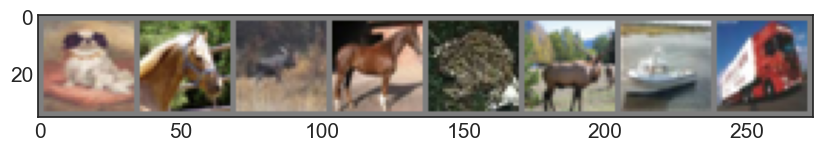

tensor([5, 7, 4, 7, 6, 4, 8, 9])
['dog', 'horse', 'deer', 'horse', 'frog', 'deer', 'ship', 'truck']


In [7]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print(labels[:8])
print([labels_name[label.item()] for label in labels[:8]])

### Early Stopping

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

### 모델 생성

In [9]:
class CIFARNet(nn.Module):
    
    def __init__(self):
        super(CIFARNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3)
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        # self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.max_pool2d(F.relu(self.conv1_2(x)), (2, 2))
        x = F.relu(self.conv2_1(x))
        x = F.max_pool2d(F.relu(self.conv2_2(x)), (2, 2))
        x = F.relu(self.conv3_1(x))
        x = F.max_pool2d(F.relu(self.conv3_2(x)), (2, 2))
        # x = self.dropout(x)
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        
        return x

##### GPU 설정

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
model = CIFARNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 학습

In [12]:
def train(model, train_loader, optimizer, losses, corrects):
    model.train()
    correct = 0
    total = len(train_loader.dataset)
    for batch, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred_label = model(image)
        
        _, predicted = torch.max(pred_label.data, 1)
        correct += (predicted == label).sum().item()
        
        loss = criterion(pred_label, label)
        loss.backward()
        optimizer.step()
        
        if not(batch % 100):
            print(f"Train Epoch : {batch * len(image)} / {len(train_loader.dataset)} | Train Loss : {loss.item():.4f}")
    
    losses.append(loss.item())
    correct = 100 * correct / total
    corrects.append(100 * correct / total)
    print(f"Train Accuracy : {correct:.2f}")

### 테스트

In [13]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            pred_label = model(image)
            test_loss += criterion(pred_label, label).item()
            _, predicted = torch.max(pred_label.data, 1)
            
            correct += (predicted == label).sum().item()
            
    test_loss /= total
    correct = 100 * correct / total
            
    return test_loss, correct

### File Path 불러오기

In [14]:
class BestScoreSave():
    
    def __init__(self, model_name, mode="accuracy", delta=0.0, save_mode="weight", vervose=True, save=False):
        self.best_score = 0 if mode == "accuracy" else np.inf   # mode가 accuracy이면 0, loss면 무한
        self.mode = mode                                        # loss : loss가 최소가 될때 저장, accuracy : accuracy가 제일 높을 때 저장
        self.save_mode = save_mode                              # weight : weight만 저장, model : model 구조와 weight 모두 저장
        self.delta = delta                                      # 작은 값 무시
        self.vervose = vervose                                  # Save 기록 출력할 것인지
        self.save = save                                        # save 할 것인지
        self.model_name = model_name                            # model명
        self.model_path = os.path.join(os.getcwd(), self.model_name)
        if not(os.path.isdir(self.model_path)):                 # 폴더 확인 후 없으면 생성
            os.mkdir(self.model_path)
        
    def __call__(self, score):
        if self.mode == "accuracy":
            if score > (self.best_score + self.delta):
                self.save = True
                self.best_score = score
            else:
                self.save = False
        elif self.mode == "loss":
            if score < (self.best_score - self.delta):
                self.save = True
                self.best_score = score
            else:
                self.save = False

### 모델 실행

In [15]:
epochs = 100
bss = BestScoreSave(model_name="CIFAR10")
es = EarlyStopping()
losses = []
corrects = []
best_score = 0
for epoch in range(epochs):
    train(model, train_loader, optimizer, losses, corrects)
    test_loss, correct = test(model, test_loader)
    print(f"Epoch : {epoch + 1} | Test Loss : {test_loss:.4f} | Test Accuracy : {correct:.2f}")
    
    file_path = os.path.join(bss.model_path, f"{bss.model_name}_{bss.save_mode}_score{correct:.4f}_epoch{epoch + 1}.pt")
    bss(correct)
    if bss.save:
        if bss.save_mode == "weight":
            torch.save(model.state_dict(), file_path)
            if bss.vervose:
                print(f"[Saved Model Weight] Epoch: {epoch + 1} | Score: {correct}")
        elif bss.save_mode == "model":
            torch.save(model, file_path)
            if bss.vervose:
                print(f"[Saved Model] Epoch: {epoch + 1} | Score: {correct}")
    else:
        if bss.vervose:
            print("[Not Saved]")
        
    
    es(test_loss)
    if es.early_stop:
        print("Early Stopping")
        break

Train Epoch : 0 / 50000 | Train Loss : 2.3015
Train Epoch : 12800 / 50000 | Train Loss : 1.8255
Train Epoch : 25600 / 50000 | Train Loss : 1.6014
Train Epoch : 38400 / 50000 | Train Loss : 1.5388
Train Accuracy : 34.86
Epoch : 1 | Test Loss : 0.0104 | Test Accuracy : 51.75
[Saved Model Weight] Epoch: 1 | Score: 51.75
[EarlyStopping] (Update) Best Score: 0.01039
Train Epoch : 0 / 50000 | Train Loss : 1.2340
Train Epoch : 12800 / 50000 | Train Loss : 1.2337
Train Epoch : 25600 / 50000 | Train Loss : 0.9312
Train Epoch : 38400 / 50000 | Train Loss : 1.0558
Train Accuracy : 59.36
Epoch : 2 | Test Loss : 0.0082 | Test Accuracy : 62.86
[Saved Model Weight] Epoch: 2 | Score: 62.86
[EarlyStopping] (Update) Best Score: 0.00819
Train Epoch : 0 / 50000 | Train Loss : 1.0632
Train Epoch : 12800 / 50000 | Train Loss : 0.8775
Train Epoch : 25600 / 50000 | Train Loss : 0.7859
Train Epoch : 38400 / 50000 | Train Loss : 0.8429
Train Accuracy : 70.39
Epoch : 3 | Test Loss : 0.0063 | Test Accuracy : 72.6

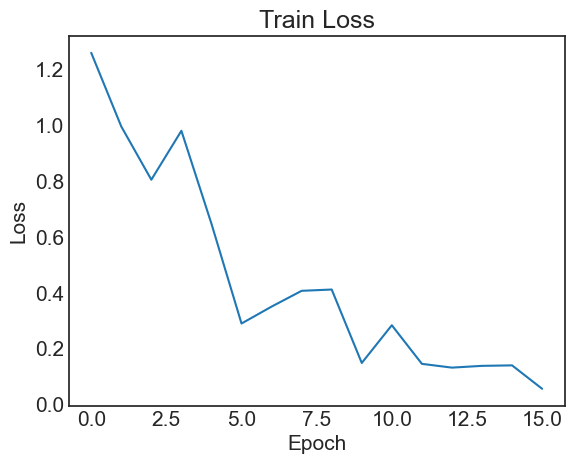

In [16]:
plt.plot(losses)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

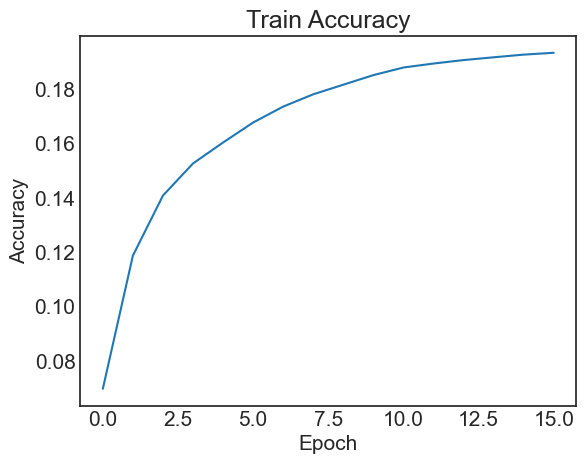

In [17]:
plt.plot(corrects)
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()